In [1]:
from astroquery.sdss import SDSS
import astropy.units as u
from astropy import coordinates as coords

import nested_pandas as npd

import numpy as np
import matplotlib.pyplot as plt

# Nested-Pandas with SDSS Spectra
The code used to actually get the SDSS data closely follows the fornax demo code here: https://github.com/nasa-fornax/fornax-demo-notebooks/blob/main/spectroscopy/code_src/sdss_functions.py

In [2]:
# Query SDSS for a set of objects with spectra
pos = coords.SkyCoord('0h8m10.63s +14d50m23.3s', frame='icrs')
xid = SDSS.query_region(pos, radius=3 * u.arcmin, spectro=True)
xid_ndf = npd.NestedFrame(xid.to_pandas())

In [3]:
xid_ndf

,ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d
0,2.076662,14.843455,1237652943176204410,1739,301,3,316,-0.000464,6112,56191,560,6881654266119084032,v5_13_2
1,2.023446,14.839824,1237652943176138868,1739,301,3,315,0.045591,751,52251,160,845594848269461504,26
2,2.016424,14.810989,1237652943176139005,1739,301,3,315,0.113535,752,52251,302,846759780839090176,26


In [4]:
# Query SDSS for the corresponding spectra
sp = SDSS.get_spectra(matches=xid, show_progress=True)

In [5]:
# Build a flat spectrum dataframe
wave=np.array([])
flux=np.array([])
err=np.array([])
index=np.array([])
for i, hdu in enumerate(sp):
    wave = np.append(wave, 10**hdu["COADD"].data.loglam) #* u.angstrom # only one entry because we only search for one xid at a time. Could change that?
    flux = np.append(flux, hdu["COADD"].data.flux*1e-17) #* u.erg/u.second/u.centimeter**2/u.angstrom 
    err = np.append(err, 1/hdu["COADD"].data.ivar*1e-17) #* flux.unit
    index = np.append(index, i*np.ones(len(hdu["COADD"].data.loglam)))

index = index.astype(np.int8)
flat_spec = npd.NestedFrame(dict(wave=wave , flux=flux, err=err), index=index)
flat_spec

/var/folders/lc/dws63_cs5gz5mf8s869hjpx40000gn/T/ipykernel_95283/2418022210.py:9: RuntimeWarning: divide by zero encountered in divide
  err = np.append(err, 1/hdu["COADD"].data.ivar*1e-17) #* flux.unit


,wave,flux,err
0,3606.617188,1.699629e-16,9.050196e-17
0,3607.447021,-4.092098e-17,7.294453e-17
0,3608.278809,5.184615e-17,7.060930e-17
0,3609.108887,1.112406e-16,9.651878e-17
0,3609.939209,7.535225e-17,8.326202e-17
...,...,...,...
2,9179.098633,1.594274e-16,1.409161e-17
2,9181.209961,1.445387e-16,1.274872e-17
2,9183.327148,1.339812e-16,1.227108e-17
2,9185.439453,1.398144e-16,1.269789e-17


In [6]:
spec_ndf = xid_ndf.add_nested(flat_spec, "coadd_spectrum").set_index("objid")
spec_ndf

,ra,dec,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d,coadd_spectrum
objid,,,,,,,,,,,,,
1237652943176204410,2.076662,14.843455,1739,301,3,316,-0.000464,6112,56191,560,6881654266119084032,v5_13_2,wave flux err...
1237652943176138868,2.023446,14.839824,1739,301,3,315,0.045591,751,52251,160,845594848269461504,26,wave flux err ...
1237652943176139005,2.016424,14.810989,1739,301,3,315,0.113535,752,52251,302,846759780839090176,26,wave flux err ...


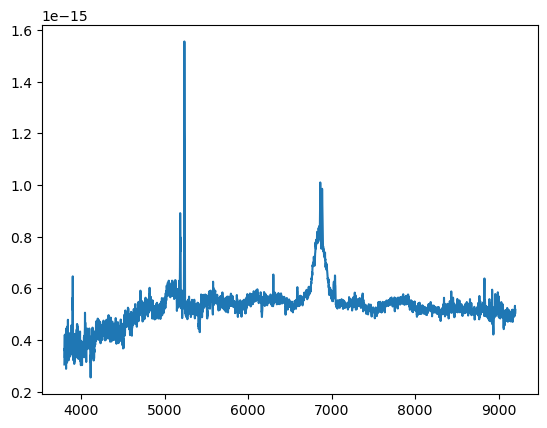

In [7]:
spec = spec_ndf.iloc[1].coadd_spectrum

plt.plot(spec["wave"], spec["flux"])

In [128]:
wave = 10**sp[0]["COADD"].data.loglam #* u.angstrom # only one entry because we only search for one xid at a time. Could change that?
flux = sp[0]["COADD"].data.flux*1e-17 #* u.erg/u.second/u.centimeter**2/u.angstrom 
err = np.sqrt(1/sp[0]["COADD"].data.ivar)*1e-17 #* flux.unit

dfsingle = npd.NestedFrame(dict(wave=[wave] , flux=[flux], err=[err]))
packed_spectra = npd.series.packer.pack_lists(dfsingle)

spec_ndf = xid_ndf.add_nested(packed_spectra, "coadd_spectrum")

/var/folders/lc/dws63_cs5gz5mf8s869hjpx40000gn/T/ipykernel_95145/4251427858.py:3: RuntimeWarning: divide by zero encountered in divide
  err = np.sqrt(1/sp[0]["COADD"].data.ivar)*1e-17 #* flux.unit


In [129]:
spec_ndf

,ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d,coadd_spectrum
0,2.076662,14.843455,1237652943176204410,1739,301,3,316,-0.000464,6112,56191,560,6881654266119084032,v5_13_2,wave flux err...
1,2.023446,14.839824,1237652943176138868,1739,301,3,315,0.045591,751,52251,160,845594848269461504,26,None
2,2.016424,14.810989,1237652943176139005,1739,301,3,315,0.113535,752,52251,302,846759780839090176,26,None
